In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
from matplotlib import style
style.use('classic')

In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
mnist['target']

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [6]:
X, y = mnist['data'], mnist['target']

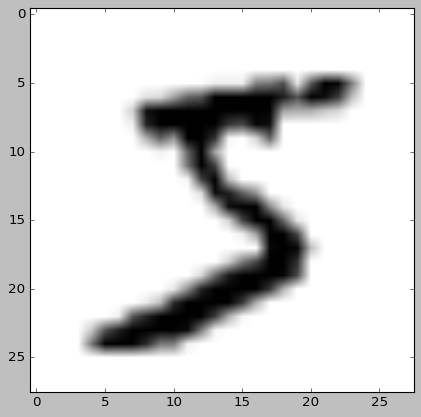

In [7]:
some_digit = X.iloc[0, :].to_numpy()
some_digit_img = some_digit.reshape(28, 28)
plt.imshow(some_digit_img, cmap='binary')
plt.show()

In [8]:
y = y.astype(np.uint8)

In [9]:
X_train, X_test, y_train, y_test = X.iloc[:60000], X.iloc[60000:], y.iloc[:60000], y.iloc[60000:], 

In [8]:
y_train_5 = y_train == 5
y_test_5 = y_test == 5

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict([some_digit])

/home/duja/ml/ml_env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfold = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfold.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train.iloc[train_index]
  y_train_folds = y_train_5.iloc[train_index]
  X_test_fold = X_train.iloc[test_index]
  y_test_fold = y_train_5.iloc[test_index]
  
  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_test_fold))

0.9669
0.91625
0.96785


In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

In [13]:
from sklearn.model_selection import cross_val_score
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

Tacnost uglavnom nije najbolja mera za procenu rada klasifikatora jer se cesto obradjuju podaci gde su neke klase manje zastupljenje od drugih.<br>
U ovom primeru imamo 10% petica tako da je model uvek 90% tacan ako prediktuje da nijedna slika nije petica.

### Matrica zabuna

In [14]:
from sklearn.model_selection import cross_val_predict

y_predict = cross_val_predict(sgd_clf, X_train, y_train_5, cv=5)

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_predict)

array([[53115,  1464],
       [  916,  4505]])

Svaki red predstavlja pravu klasu, a svaka kolona predvidjenu klasu. <br>
[0, 0] -> nisu petice<br>
[0, 1] -> pogresno prepoznate da jesu petice (lazna pozitiva)<br>
[1, 0] -> pogresno prepoznate da nisu petice (lazna negativa)<br>
[1, 1] -> prave petice<br>

##### Jednacina za preciznost<br>
$precision = \frac{TP}{TP + FP}$<br><br>
TP - prave pozitive<br>
FP - lazne pozitive

##### Jednacina za prepoznavanje<br>
$recall = \frac{TP}{TP + FN}$<br><br>
TP - prave pozitive<br>
FN - lazne negative

In [16]:
from sklearn.metrics import precision_score, recall_score

print("Precision: ", precision_score(y_train_5, y_predict))
print("Recall: ", recall_score(y_train_5, y_predict))


Precision:  0.7547327860613168
Recall:  0.8310274857037447


##### $F_1$ rezultat<br>
$F_1 = \frac{2}{\frac{1}{preciznost} + \frac{1}{prepoznavanje}} = 2 * \frac{preciznost * prepoznavanje}{preciznost + prepoznavanje}$


In [17]:
from sklearn.metrics import f1_score

print("F1 score: ", f1_score(y_train_5, y_predict))

F1 score:  0.791044776119403


In [18]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

/home/duja/ml/ml_env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [19]:
threshold = 0
y_some_digit_pred = y_scores > threshold

In [20]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [21]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [22]:
def plot_precision_recallVSthreshold(precisions, recalls, thresholds):
  threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
  y_train_pred_90 = y_scores >= threshold_90_precision
  precision_90 = precision_score(y_train_5, y_train_pred_90)
  recall_90 = recall_score(y_train_5, y_train_pred_90)
  plt.yticks([0.0, 0.25, 0.5, 0.75, 1.0, precision_90, recall_90])
  plt.plot(thresholds, precisions[:-1], 'b--', label="Preciznost")
  plt.plot(thresholds, recalls[:-1], 'g-', label="Prepoznavanje")
  plt.scatter([threshold_90_precision, threshold_90_precision], [precision_90, recall_90])
  plt.plot([-45000, threshold_90_precision], [precision_90, precision_90], 'k--', alpha=0.5)
  plt.plot([-45000, threshold_90_precision], [recall_90, recall_90], 'k--', alpha=0.5)
  plt.plot([threshold_90_precision, threshold_90_precision], [0.0, precision_90], 'k--', alpha=0.5)
  plt.legend(loc="center right")
  plt.xlim(-45000, 45000)
  plt.ylim(0.0, 1.0)
  plt.xlabel('Vrednost praga')
  plt.grid(True)

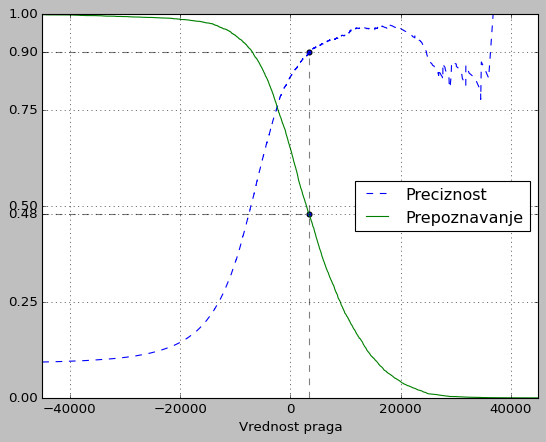

In [23]:
plot_precision_recallVSthreshold(precisions, recalls, thresholds)

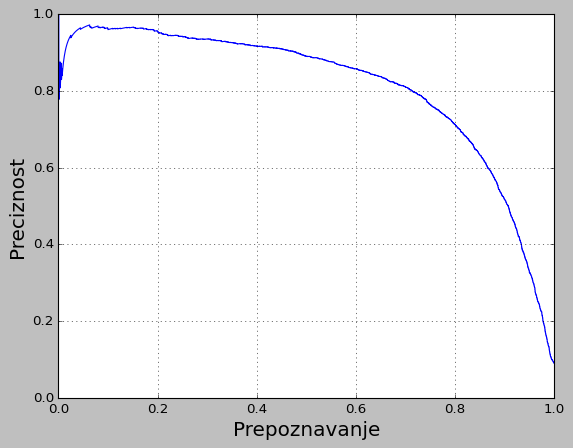

In [24]:
plt.plot(recalls[:-1], precisions[:-1])
plt.xlabel('Prepoznavanje', fontsize=18)
plt.ylabel('Preciznost', fontsize=18)
plt.grid(True)


#### ROC kriva (kriva operativne karakteristike prijemnika)

ROC kriva prikazuje prepoznavanje kao funkciju stope laznih pozitiva FPR<br>
ROC kriva prikazuje osetljivost(prepoznavanje) u odnosu na specificnost

In [25]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [26]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--')
  plt.grid(True)
  plt.xlabel('Stopa laznih pozitiva', fontsize=18)
  plt.ylabel('Stopa pravih pozitiva (prepoznavanje)', fontsize=18)

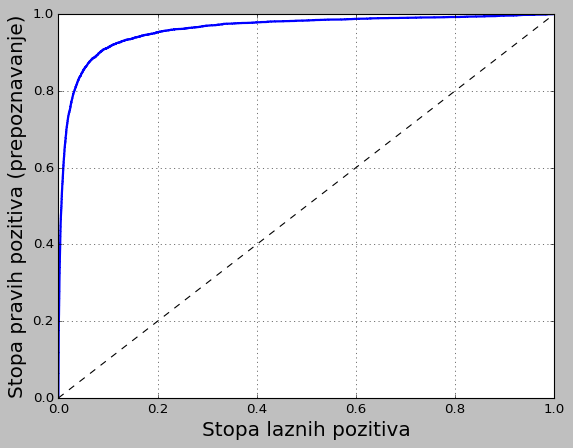

In [27]:
plot_roc_curve(fpr, tpr)

Nacin za medjusobno poredjenje dva klasifikatora je merenje povrsine ipod krive (area under curve AUC). Sto je bolji klasifikator to ce mu ROC AUC biti blizi 1, dok ce skroz nasumicni klasifikator imati ROC AUC 0.5

In [28]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

## <b>Kriva PP se koristi kada ima malo pozitivnih primera kao u ovom slucaju </b>

In [29]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [33]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

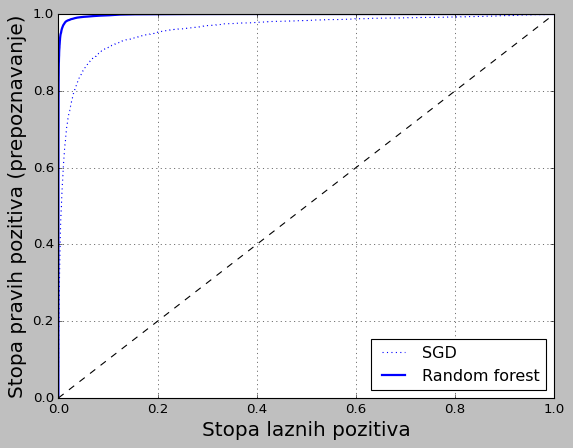

In [34]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random forest")
plt.legend(loc="lower right")
plt.show()

#### Viseklasna klasifikacija

Sastoji se od treniranja vise binarnih klasifikatora i njihovom kombinacijom <br>
Strategije su:
1. Jedan nasuprot ostalih (OvR) -> za svaku klasu se napravi klasifikator i kada hocemo da klasifikujemo damo svima isti ulaz i odaberemo onaj koji je najvise siguran
2. Jedan nasuprot jedan (OvO) -> za svaki par klasa se napravi klasifikator ukupno $\frac{N * (N - 1)}{2}$ klasifikatora. Prednost OvO metode je da se svaki klasifikator trenira samo na tom podskupu od dve klase

In [11]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)

SVC()

In [12]:
svm_clf.predict([some_digit])

/home/dujapc/ml/ml_env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [13]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

/home/dujapc/ml/ml_env/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(svm_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.977 , 0.9738, 0.9739])

In [17]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)

SGDClassifier()

In [25]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_predict

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

In [26]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5668,    1,   63,   26,   15,   63,   28,    3,   42,   14],
       [   3, 6510,   40,   39,    7,   18,    7,    8,  104,    6],
       [  74,  110, 5041,  261,   55,   48,   79,   65,  209,   16],
       [  30,   31,  185, 5109,    9,  388,   12,   54,  213,  100],
       [  17,   44,   49,   53, 5086,   49,   44,   31,  155,  314],
       [  85,   28,   41,  252,   59, 4051,   90,   19,  714,   82],
       [  64,   14,   90,   16,   46,  167, 5440,    3,   69,    9],
       [  28,   51,   82,   70,   68,   23,    3, 5595,   64,  281],
       [  54,  212,  178,  285,   21,  490,   30,   22, 4384,  175],
       [  49,   51,   29,  147,  193,   72,    1,  290,  598, 4519]])

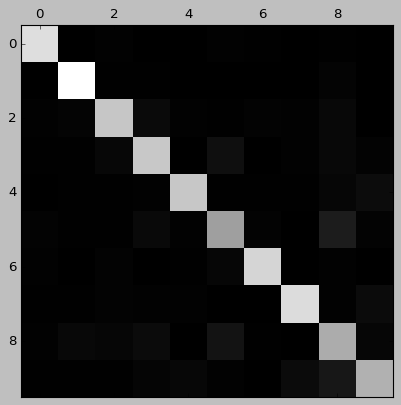

In [28]:
plt.matshow(conf_mx, cmap=plt.cm.gray)